In [1]:
import logging
import math3d as m3d #the library, used by urx to represent transformations
import numpy as np
import time

from IPython.display import clear_output
from tqdm.notebook import tqdm

from custom_classes.robot_bridge import RobotBridge
from custom_classes.custom_surface import CustomSurface

# import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# import time
# from IPython.display import clear_output
from PIL import Image
import matplotlib.image as mpimg

import math3d as m3d


In [2]:
# robotIP = "192.168.88.95" (via network)
robotIP = "10.42.1.10"
acc = 0.5
vel = 0.01 # 1%

In [3]:
robot = RobotBridge(robotIP)

In [4]:
robot.is_connected()

False

In [5]:
robot.connect()

tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 68
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1092
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1418


True

In [6]:
robot.is_connected()

True

In [7]:
robot.get_pose()

<Transform:
<Orientation: 
array([[ 0.99487226, -0.08828606,  0.04934334],
       [ 0.09688013,  0.97195658, -0.21427705],
       [-0.02904191,  0.21795868,  0.9755258 ]])>
<Vector: (0.06815, -0.35275, 0.63809)>
>

In [71]:
new_robot_pose = np.array([0, -0.265, 0.5, 0, 0, 0])
new_pose = m3d.Transform(new_robot_pose)
new_pose

<Transform:
<Orientation: 
array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])>
<Vector: (0.00000, -0.26500, 0.50000)>
>

In [42]:
import math
ry = math.radians(1.1)

0.019198621771937627

In [52]:
rx = -math.radians(1.1)
rx

-0.019198621771937627

In [61]:
default_robot_j = robot.device.getj()
default_robot_j

[0.8215388655662537,
 -2.3737624327289026,
 2.1293883323669434,
 4.982828140258789,
 1.5808305740356445,
 -5.531112615262167]

In [72]:
robot.device.movej(default_robot_j, acc=0.2, vel=0.2)

RobotException: Robot stopped

In [27]:
robot.device.getl()

[1.4773074713200515e-05,
 -0.30000764707082683,
 0.5499904979417003,
 1.6428278108457825e-05,
 -3.4135966827967964e-05,
 0.00010175373828150364]

In [70]:
robot.device.movel(new_robot_pose, acc=0.01, vel=0.01, wait=True, relative=False, threshold=None)

RobotException: Robot stopped

In [17]:
robot.get_pose()

<Transform:
<Orientation: 
array([[  9.99823344e-01,  -5.37724787e-04,  -1.87880816e-02],
       [ -7.24484234e-04,   9.97745318e-01,  -6.71100256e-02],
       [  1.87818072e-02,   6.71117819e-02,   9.97568671e-01]])>
<Vector: (-0.00887, -0.43081, 0.62433)>
>

In [31]:

outfile = "example.npy"
x = np.arange(10)
np.save(outfile, x)


In [32]:
# _ = outfile.seek(0) # Only needed here to simulate closing & reopening file
y = np.load(outfile)
y

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [41]:
filename = "matrices.txt"

max_iters = 700
n = 0
get_poses = True

poses_array = []
while get_poses:
    clear_output(True)
    time.sleep(0.1)
    pose = robot.get_pose() # current pose of robot
    print(n, pose.get_matrix())
    poses_array.append(pose.get_matrix())

    n+=1
    if n == max_iters:
        get_poses = False


699 [[ 0.85421844 -0.50347201  0.1297181   0.21054403]
 [ 0.51929979  0.83835291 -0.16580748 -0.28823495]
 [-0.02527012  0.20899839  0.97758943  0.6387437 ]
 [ 0.          0.          0.          1.        ]]


In [42]:
data = np.array(poses_array)
print(data.shape)
filename = "pose_matrices.npy"
np.save(filename, data)

(700, 4, 4)


In [43]:
new_data = np.load(filename)
new_data.shape

(700, 4, 4)

In [9]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

/usr/lib/python3/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


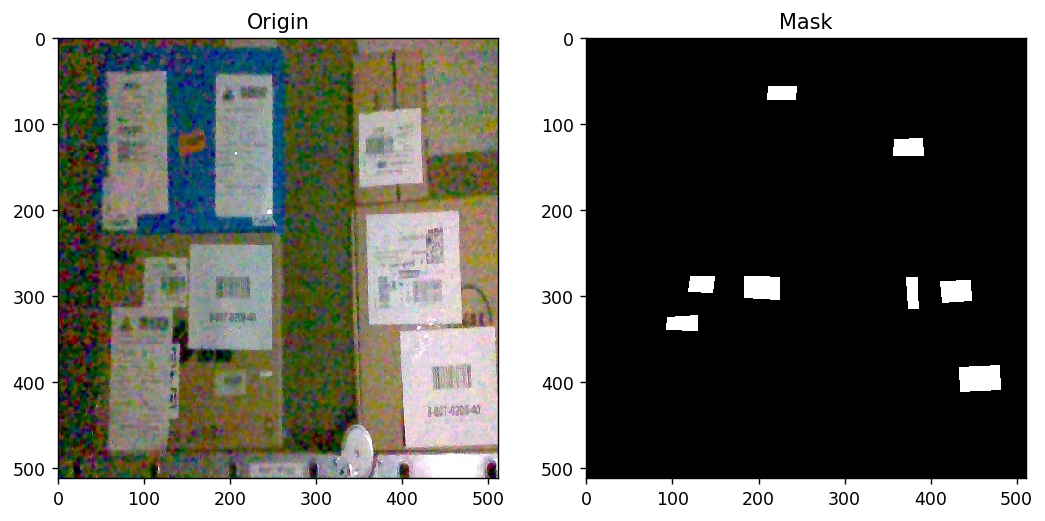

In [10]:
img = mpimg.imread('mask.png')
gray_mask = rgb2gray(img)

img = mpimg.imread('origin.png')
gray_origin = rgb2gray(img)

fig = plt.figure(figsize=(10,20), dpi=125)
ax1 = fig.add_subplot(121)
ax1.imshow(img)
ax1.set_title("Origin")

ax2 = fig.add_subplot(122)
ax2.imshow(gray_mask, cmap = plt.get_cmap('gray'))
ax2.set_title("Mask")

fname = "2D_images"
fig.savefig('{}.png'.format(fname), transparent=True)
fig.show()

In [54]:
def get_xyzuvctt(T):
    T = np.array(T)
    t = np.squeeze(T[:3, 3:4].flatten()) 
    R = T[:3,:3]
    (x, y, z) = np.repeat(t.reshape(3,1),3, axis=1)
    (u, v, c) = R
    return x, y, z, u, v, c, t


def polygon_under_graph(xlist, ylist):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (xlist, ylist) line graph.  Assumes the xs are in ascending order.
    """
    return [(xlist[0], 0.), *zip(xlist, ylist), (xlist[-1], 0.)]


def plot_pose(poses=None, faces=None, plane=(100,90,-150), view=(30,-25),  fname = None, pose_size = 15, origin_size = 25, trajectory = None, trajectory_shift = None, resolution=100, image=None, legend=False):
    fig = plt.figure(figsize=(10,10), dpi=resolution)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=view[0], azim=view[1])
#     ax.view_init(elev=0, azim=90)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    
    
    #origin and coordinate axes (coordinate frame)
    xl = 'x'; yl = 'y'; zl = 'z'; ol = '0'
    x, y, z, u, v, c, t = get_xyzuvctt(np.eye(4))
    ax.scatter(t[0], t[1], t[2], s=8, c='k')
    ax.quiver(x, y, z, u, v, c, color='k', length=origin_size, arrow_length_ratio=0.1, linewidth=0.5)
    ax.text(origin_size, 0, 3, xl); ax.text(0, origin_size, 3, yl); ax.text(3, 0, origin_size,zl)

    for surface in faces:
        if surface in poses:
            center_m = np.array(poses[surface])[:3,3]
            rotate_m = m3d.Transform(np.array(poses[surface])).get_pose_vector()[3:]
            pl = Poly3DCollection(faces[surface].get_rotated_polygon(center=center_m, rotation=rotate_m), linewidths=0)
            pl.set_alpha(0.25)   # Order reversed 
            pl.set_facecolor('c')
            ax.add_collection3d(pl)

    if trajectory is not None and trajectory_shift is not None:
        ax.plot(trajectory[0]+trajectory_shift[0], np.zeros(trajectory[0].shape[0]) + trajectory_shift[1], trajectory[1]+trajectory_shift[2], 'k', label='Trajectory')
        
#     poses = {'origin': T, 'camera': T, 'scanner': T}    
    for pose in poses:
        x, y, z, u, v, c, t = get_xyzuvctt(poses[pose])
        ax.quiver(x, y, z, u, v, c, length=pose_size, arrow_length_ratio=0, color=['r','g','b'], linestyle='-', linewidth=2)
        ax.text(t[0] + 5, t[1] + 5, t[2] + 1, "%s (%.02f,%.02f,%.02f)" % (pose, t[0], t[1], t[2]), color='black', bbox=dict(facecolor='red', alpha=0.5))
        

    # draw the stand
    x_size_wall = plane[0]
    z_size_wall = plane[1]
    y_wall_range = plane[2]

    if image is not None:
        # create a vertex mesh
        im_size = image.shape[0]
        xx, yy = np.meshgrid(np.linspace(-plane[0]/2, plane[0]/2, im_size), np.linspace(0, plane[1], im_size))
        X =  xx 
        Z =  yy
        cset = ax.contourf(X, np.flip(np.flip(image, 0), 1), Z, 100, zdir='y', offset=plane[2], cmap = plt.get_cmap('gray'))
    else:
        x_wall = np.linspace(-x_size_wall/2, x_size_wall/2, 26)
        z_wall = np.ones(x_wall.shape[0])*z_size_wall

        # The ith polygon will appear on the plane y = zs[i]
        verts = [polygon_under_graph(x_wall, z_wall)]
        poly = PolyCollection(verts, facecolors=['r'], alpha=.3)
        ax.add_collection3d(poly, zs=y_wall_range, zdir='y')

        ax.text(x_wall.mean(), y_wall_range, z_wall.mean(), "Stand with barcodes")
        
    
    xlim_all = abs(y_wall_range - 5)
    ax.set_xlim(-5-xlim_all/2, 5+xlim_all/2)
    ax.set_ylim(-xlim_all, origin_size)
    ax.set_zlim(0, xlim_all+10)
    
    
#     ax.
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    plt.rcParams['grid.color'] = "#dddddd"
    plt.subplots_adjust()
    if legend:
        plt.legend()
    
    if fname is not None:
        fig.savefig('{}.png'.format(fname), transparent=True)
    
#     plt.show()

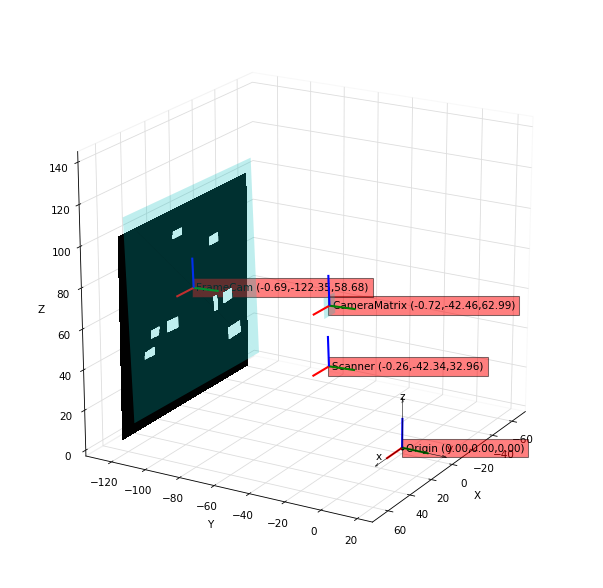

In [58]:
# Define poses:
T0 = np.eye(4)

Tcamera_zero = np.eye(4); Tcamera_zero[:3, 3] = np.array([0, -30, 65])
Tcamera = np.copy(Tcamera_zero)

# getting real data from UR
pose = robot.get_pose()
Tcamera = np.array(pose.get_matrix())
Tcamera[:3,3] = Tcamera[:3,3]*100

# print(Tcamera[:3,3]*100)

axis_scanner = np.zeros(6)
axis_scanner[:3] = np.array([0, -1.5, -30])
Tscanner = Tcamera@m3d.Transform(axis_scanner).get_matrix()

axis_surface = np.zeros(6)
axis_surface[:3] = np.array([0, -80, 0])
Tsurface = Tcamera@m3d.Transform(axis_surface).get_matrix()
        
poses = {"Origin": T0,
         "CameraMatrix": Tcamera,
         "Scanner": Tscanner,
         "FrameCam": Tsurface}

plane = (110, 100, -127)
serf_camera_matrix = CustomSurface(right_top=(5,0,5))
serf_camera_frame = CustomSurface(right_top=(plane[0]/2,0,plane[1]/2))

faces = {"CameraMatrix": serf_camera_matrix,
         "FrameCam": serf_camera_frame}

# plot_pose(poses=poses, plane=(110, 100, -100), view=(20,30), pose_size = 15, image=gray_origin, fname='3D_origin')
plot_pose(poses=poses, resolution=75, faces=faces, plane=plane, view=(20,30), pose_size = 15, image=gray_mask, legend=False)

In [51]:
import os
folder_name = "0_common_anim"
if not os.path.exists('./{}'.format(folder_name)):
    os.mkdir('./{}'.format(folder_name))

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f8ef7e378> (for post_execute):


AttributeError: 'Poly3DCollection' object has no attribute '_vec'

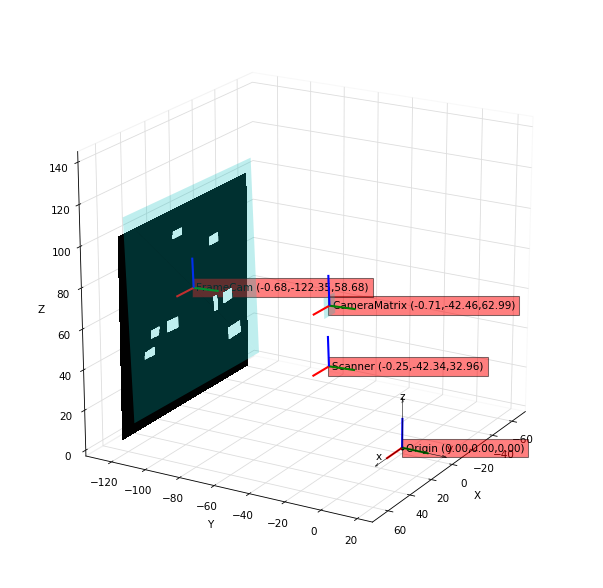

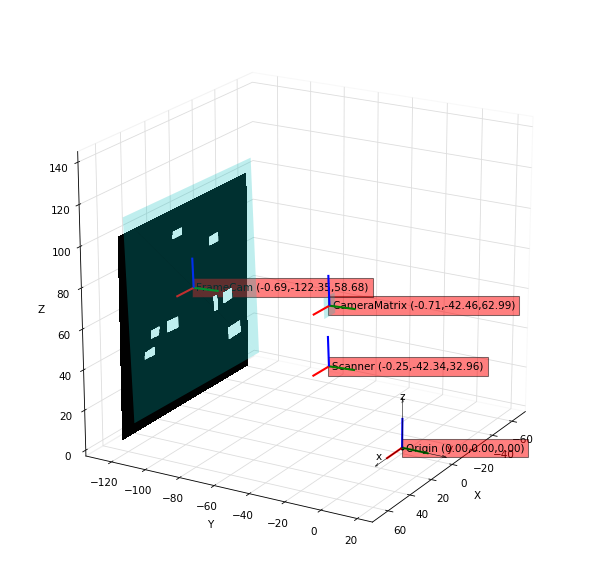

Error in callback <function flush_figures at 0x7f8ef772f0> (for post_execute):


KeyboardInterrupt: 

In [59]:
frame_num = 0
while True:
    time.sleep(0.01)
    clear_output(wait=True)

    pose = robot.get_pose()
    Tcamera = np.array(pose.get_matrix())
    Tcamera[:3,3] = Tcamera[:3,3]*100

    axis_scanner = np.zeros(6)
    axis_scanner[:3] = np.array([0, -1.5, -30])
    Tscanner = Tcamera@m3d.Transform(axis_scanner).get_matrix()

    axis_surface = np.zeros(6)
    axis_surface[:3] = np.array([0, -80, 0])
    Tsurface = Tcamera@m3d.Transform(axis_surface).get_matrix()

    poses = {"Origin": T0,
             "CameraMatrix": Tcamera,
             "Scanner": Tscanner,
             "FrameCam": Tsurface}

    faces = {"CameraMatrix": serf_camera_matrix,
             "FrameCam": serf_camera_frame}
    fname = "{}/pic{:04d}".format(folder_name, frame_num)
    # plot_pose(poses=poses, plane=(110, 100, -100), view=(20,30), pose_size = 15, image=gray_origin, fname='3D_origin')
    plot_pose(fname=fname, resolution=75, poses=poses, faces=faces, plane=plane, view=(20,30), pose_size = 15, image=gray_mask, legend=False)

    if frame_num%120 == 0 and frame_num>0:
        break

    frame_num +=1
    